In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import scipy
import joblib
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy
import matplotlib.patches as mpatches

In [2]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
gps_time = t0_gps + duration/2

delta = 1
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))
RA, DEC = np.meshgrid(ras, decs)

In [3]:
def whiten(strain_df, psd_df):
    return strain_df['h'] / np.sqrt(psd_df['PSD'])

def match_filter(strain_df, waveform_df, IFO, sampling_frequency=sampling_frequency, gps_time=gps_time, psi=0):
    mask = strain_df['Hz'] > 20
    S = IFO.power_spectral_density.psd_array
    S[~mask] = np.inf
    best_rhosq = 0
    df = waveform_df['Hz'][1] - waveform_df['Hz'][0]
    n = len(waveform_df['Hz'])

    for ra in ras:
        for dec in decs:
            fplus = IFO.antenna_response(ra, dec, gps_time, psi, 'plus')
            fcross = IFO.antenna_response(ra, dec, gps_time, psi, 'cross')
            template = fplus*waveform_df['h+'] + fcross*waveform_df['hx']
            Z = strain_df['h']*np.conj(template)/S
            Z_full = np.zeros(2*n, dtype=complex)
            Z_full[:n] = Z[0:]
            Z_full[-n+1:] = np.conj(Z[1:][::-1])
            rhosq = 4*np.fft.ifft(Z_full).real*sampling_frequency
            # N = 4*np.sum(np.abs(template)**2/S) * df
            real_rhosq = rhosq.real#np.abs(rhosq)/np.sqrt(N)
            if np.max(real_rhosq) > best_rhosq:
                best_rhosq = np.max(real_rhosq)
                best_ra = ra
                best_dec = dec
                best_rhosqs = real_rhosq
                
    return best_rhosq, best_ra, best_dec, best_rhosqs

def get_tc(snr, time):
    peak_idx = np.argmax(np.abs(snr))
    peak_time = time[peak_idx]
    peak_val = np.abs(snr[peak_idx])
    half_max = peak_val / 2
    indices = np.where(np.abs(snr) > half_max)[0]
    fwhm = time[indices[-1]] - time[indices[0]]
    return peak_time, fwhm

def probalistic_loc_plot(dts, sigmas, flag):
    # Define H1 and L1 locations
    H1_loc = astropy.coordinates.EarthLocation.of_site('H1')
    L1_loc = astropy.coordinates.EarthLocation.of_site('L1')
    V1_loc = astropy.coordinates.EarthLocation.of_site('V1')

    # Convert to numpy arrays
    H1_loc = np.asarray(tuple(H1_loc.to_value()))
    L1_loc = np.asarray(tuple(L1_loc.to_value()))
    V1_loc = np.asarray(tuple(V1_loc.to_value()))

    # Calculate distance
    D_HL = (H1_loc - L1_loc)/scipy.constants.c
    D_HV = (H1_loc - V1_loc)/scipy.constants.c
    D_LV = (L1_loc - V1_loc)/scipy.constants.c

    # Healpy parameters
    nside = 64
    npix = hp.nside2npix(nside)
    pix_indices = np.arange(npix)

    # Pixel positions (RA, Dec)
    ra, dec = hp.pix2ang(nside, pix_indices, lonlat=True)

    # Unit vector in the direction of each pixel
    n_hat = np.array([np.cos(np.radians(dec)) * np.cos(np.radians(ra)),
                    np.cos(np.radians(dec)) * np.sin(np.radians(ra)),
                    np.sin(np.radians(dec))]).T  # shape (npix, 3)

    # Model time delays
    dt_model_HL = np.dot(n_hat, D_HL)
    dt_model_HV = np.dot(n_hat, D_HV)
    dt_model_LV = np.dot(n_hat, D_LV)

    if flag == 'HL':

        # Likelihood
        likelihood = np.exp(-0.5 * ((dt_model_HL - dts[0]) ** 2) / sigmas[0] ** 2)

        # Mollweide projection
        hp.newvisufunc.projview(likelihood, 
                            coord=["C"],
                            graticule=True, 
                            graticule_labels=True,
                            projection_type="mollweide",
                            xlabel="RA",
                            ylabel="Dec",
                            latitude_grid_spacing=30,
                            cb_orientation="vertical",
                            cmap='viridis_r'
                            )
        # hp.mollview(likelihood, coord=["C"])
        # hp.graticule()

        max_idx = np.argmax(likelihood)
        max_ra, max_dec = ra[max_idx], dec[max_idx]
        print(f"Most probable location: RA = {max_ra:.2f} deg, Dec = {max_dec:.2f} deg")

        max_ra_wrapped = max_ra if max_ra <= 180 else max_ra - 360
        hp.newvisufunc.newprojplot(max_ra_wrapped, max_dec, 'ro', lonlat=True)


        # Save the plot
        plt.savefig("figures/HL_loc_plot.png")

        # Show the plot
        plt.show()
    elif flag == 'HLV':

        # Likelihood
        likelihood = 1
        for model, dt, sigma_dt in zip([dt_model_HL, dt_model_HV, dt_model_LV], dts, sigmas):
            likelihood *= np.exp(-0.5 * ((model - dt) ** 2) / sigma_dt ** 2)

        # Mollweide projection
        # hp.mollview(likelihood, coord=["C"])
        # hp.graticule()

        hp.newvisufunc.projview(likelihood, 
                            coord=["C"],
                            graticule=True, 
                            graticule_labels=True,
                            projection_type="mollweide",
                            xlabel="RA",
                            ylabel="Dec",
                            latitude_grid_spacing=30,
                            cb_orientation="vertical",
                            cmap='viridis_r'
                            )

        max_idx = np.argmax(likelihood)
        max_ra, max_dec = ra[max_idx], dec[max_idx]
        print(f"Most probable location: RA = {max_ra:.2f} deg, Dec = {max_dec:.2f} deg")

        max_ra_wrapped = max_ra if max_ra <= 180 else max_ra - 360
        hp.newvisufunc.newprojplot(max_ra_wrapped, max_dec, 'ro', lonlat=True)


        # Save the plot
        plt.savefig("figures/HLV_loc_plot.png")

        # Show the plot
        plt.show()

def calculate_time_delay_grid(RA, DEC):
    """
    Calculate time delays for all sky positions using bilby's method
    """
    
    time_delays_HLV = np.zeros(shape=(RA.shape[0], RA.shape[1], 3))
    
    for i in range(RA.shape[0]):
        for j in range(RA.shape[1]):
            ra = RA[i, j]
            dec = DEC[i, j]
            
            h1_delay = IFOH.time_delay_from_geocenter(ra, dec, gps_time)
            l1_delay = IFOL.time_delay_from_geocenter(ra, dec, gps_time)
            v1_delay = IFOV.time_delay_from_geocenter(ra, dec, gps_time)
            
            time_delays_HLV[i, j, 0] = h1_delay - l1_delay  # H1-L1
            time_delays_HLV[i, j, 1] = h1_delay - v1_delay  # H1-V1
            time_delays_HLV[i, j, 2] = v1_delay - l1_delay  # V1-L1
    
    return time_delays_HLV

def detector_skymap(detector_delays, measured_delays, sigmas):
    masks = np.zeros(shape=np.array(detector_delays).shape, dtype=bool)
    for i, (detector_delay, measured_delay, sigma) in enumerate(zip(detector_delays.T, measured_delays, sigmas)):
        mask = np.abs(detector_delay.T - measured_delay) <= sigma
        masks[:,:,i] = mask
    return masks

def plot_detector_skymap(RA, DEC, masks):
    RA = RA-np.pi

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': 'mollweide'})
    ax[0].pcolormesh(RA, DEC, np.where(masks[:,:,0], 1, np.nan), cmap='winter_r', shading='auto', vmin=0.5, vmax=1.2,)
    ax[0].set_title('H1 & L1')
    ax[0].grid(True)
    ax[0].set_xlabel('RA (rad)')
    ax[0].set_ylabel('Dec (rad)')

    ax[1].pcolormesh(RA, DEC, np.where(masks[:,:,0]&masks[:,:,1]&masks[:,:,2], 1, np.nan), cmap='autumn_r', shading='auto', vmin=0.5, vmax=1.2,)
    ax[1].set_title('H1, L1 & V1')
    ax[1].grid(True)
    ax[1].set_xlabel('RA (rad)')
    plt.tight_layout()
    plt.show()
    plt.savefig("figures/detector_skymap_compare.png", bbox_inches='tight', dpi=300)

    pixels = RA.size
    sky_area = 4*np.pi*(180/np.pi)**2 / pixels

    print(f"Sky area covered by H1 & L1: {np.sum(masks[:,:,0]) * sky_area:.2f} square degrees")
    print(f"Sky area covered by H1, L1 & V1: {np.sum(masks[:,:,0] & masks[:,:,1] & masks[:,:,2]) * sky_area:.2f} square degrees")
    improvement = np.sum(masks[:,:,0]) / np.sum(masks[:,:,0] & masks[:,:,1] & masks[:,:,2])
    print(f"Improvement in sky area with V1: {improvement:.2f} times smaller area")
    print(f"Sky area reduction: {(1 - 1/improvement) * 100:.2f}%")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'mollweide'})
    for i, (ax, mask, cmap, name) in enumerate(zip(axes, masks.T, ['winter_r', 'summer', 'spring'], ['H1', 'L1', 'V1'])):
        ax.set_title(f'{name}')
        ax.pcolormesh(RA, DEC, np.where(mask.T, 1, np.nan), cmap=cmap, shading='auto', vmin=0.5, vmax=1.2,)
        ax.grid(True)
        ax.set_xlabel('RA (rad)')
    axes[0].set_ylabel('Dec (rad)')

    plt.tight_layout()
    plt.show()
    plt.savefig("figures/detector_skymap_ind.png", bbox_inches='tight', dpi=300)

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': 'mollweide'})
    colors = ['blue', 'green', 'orange']
    for i, (mask, color, ) in enumerate(zip(masks.T, colors)):
        ax.contourf(RA, DEC, np.where(mask.T, 1, np.nan), levels=[0.5, 1.5], colors=color, alpha=0.3)
    ax.contourf(RA, DEC, np.where(masks[:,:,0] & masks[:,:,1] & masks[:,:,2], 1, np.nan), levels=[0.5, 1.5], colors='red')
    handles = [mpatches.Patch(color=color, alpha=0.3, label=name) for color, name in zip(colors, ['H1', 'L1', 'V1'])]
    handles.append(mpatches.Patch(color='red', label='H1 & L1 & V1'))
    ax.grid(True)
    ax.set_xlabel('RA (rad)')
    ax.set_ylabel('Dec (rad)')
    plt.tight_layout()
    plt.legend(handles=handles)
    plt.show()
    plt.savefig("figures/detector_skymap_intersection.png", bbox_inches='tight', dpi=300)

In [4]:
waveform = np.loadtxt('data/waveform.txt')
h1_strain = np.loadtxt('data/H1_strain.txt')
l1_strain = np.loadtxt('data/L1_strain.txt')
v1_strain = np.loadtxt('data/V1_strain.txt')
h1_psd = np.loadtxt('data/H1_psd.txt')
l1_psd = np.loadtxt('data/L1_psd.txt')
v1_psd = np.loadtxt('data/V1_psd.txt')

In [5]:
waveform = pd.DataFrame(data=waveform, columns=['Hz', 'Re(h+)', 'Im(h+)', 'Re(hx)', 'Im(hx)'])

h1_strain = pd.DataFrame(data=h1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
l1_strain = pd.DataFrame(data=l1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])
v1_strain = pd.DataFrame(data=v1_strain, columns=['Hz', 'Re(h)', 'Im(h)'])

h1_psd = pd.DataFrame(data=h1_psd, columns=['Hz', 'PSD'])
l1_psd = pd.DataFrame(data=l1_psd, columns=['Hz', 'PSD'])
v1_psd = pd.DataFrame(data=v1_psd, columns=['Hz', 'PSD'])

In [6]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=h1_psd['Hz'].values, psd_array=h1_psd['PSD'].values)

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=l1_psd['Hz'].values, psd_array=l1_psd['PSD'].values)

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=v1_psd['Hz'].values, psd_array=v1_psd['PSD'].values)

In [7]:
waveform['h+'] = waveform['Re(h+)'] + 1j*waveform['Im(h+)']
waveform['hx'] = waveform['Re(hx)'] + 1j*waveform['Im(hx)']

h1_strain['h'] = h1_strain['Re(h)'] + 1j*h1_strain['Im(h)']
l1_strain['h'] = l1_strain['Re(h)'] + 1j*l1_strain['Im(h)']
v1_strain['h'] = v1_strain['Re(h)'] + 1j*v1_strain['Im(h)']

snr_H1 = match_filter(h1_strain, waveform, IFOH)[-1]
snr_L1 = match_filter(l1_strain, waveform, IFOL)[-1]
snr_V1 = match_filter(v1_strain, waveform, IFOV)[-1]

time = np.arange(len(snr_H1)) / sampling_frequency

tc_H1, fwhm_H1 = get_tc(snr_H1, time)
tc_L1, fwhm_L1 = get_tc(snr_L1, time)
tc_V1, fwhm_V1 = get_tc(snr_V1, time)

files = {
    'waveform': waveform,
    'h1_strain': h1_strain,
    'l1_strain': l1_strain,
    'v1_strain': v1_strain,
    'h1_psd': h1_psd,
    'l1_psd': l1_psd,
    'v1_psd': v1_psd,
}

data = {}

for name, df in files.items():
    data[name] = {col: df[col].values for col in df.columns}

joblib.dump(data, 'data/data.pkl')

time_delays_HLV = calculate_time_delay_grid(RA, DEC)

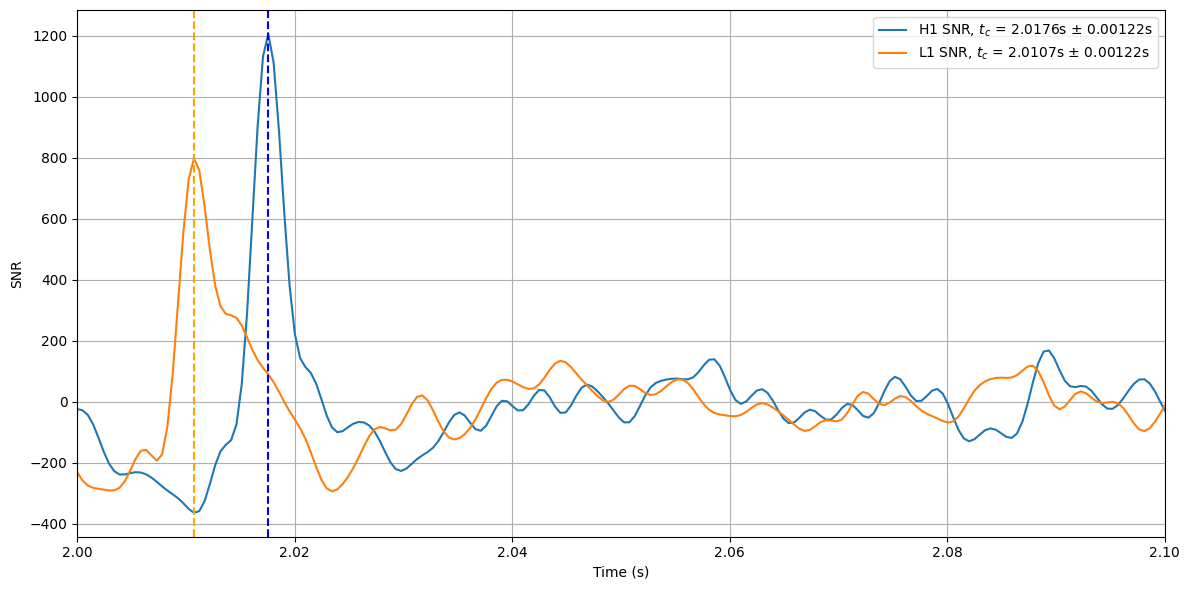

In [8]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time, snr_H1, label=fr'H1 SNR, $t_c$ = {tc_H1:.4f}s ± {fwhm_H1/2:.5f}s')
ax.plot(time, snr_L1, label=fr'L1 SNR, $t_c$ = {tc_L1:.4f}s ± {fwhm_L1/2:.5f}s')
ax.axvline(tc_H1, color='blue', linestyle='--')
ax.axvline(tc_L1, color='orange', linestyle='--')
ax.grid()
ax.legend()
ax.set_xlim(2, 2.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('SNR')
plt.tight_layout()
plt.savefig('figures/HL_snr.png')
plt.show()

In [9]:
print(fr"TIME DELAY (H1-L1): {tc_H1-tc_L1:.4f} ± {(fwhm_H1 + fwhm_L1)/2:.5f} s")

TIME DELAY (H1-L1): 0.0068 ± 0.00244 s


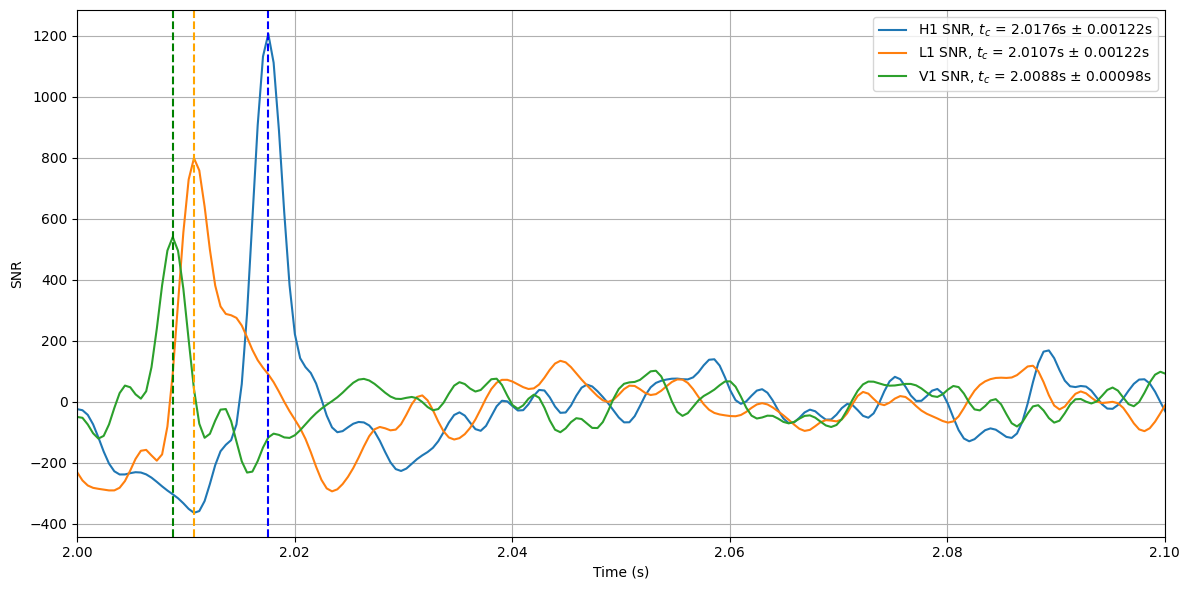

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(time, snr_H1, label=fr'H1 SNR, $t_c$ = {tc_H1:.4f}s ± {fwhm_H1/2:.5f}s')
ax.plot(time, snr_L1, label=fr'L1 SNR, $t_c$ = {tc_L1:.4f}s ± {fwhm_L1/2:.5f}s')
ax.plot(time, snr_V1, label=fr'V1 SNR, $t_c$ = {tc_V1:.4f}s ± {fwhm_V1/2:.5f}s')
ax.axvline(tc_H1, color='blue', linestyle='--')
ax.axvline(tc_L1, color='orange', linestyle='--')
ax.axvline(tc_V1, color='green', linestyle='--')
ax.grid()
ax.legend()
ax.set_xlim(2, 2.1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('SNR')
plt.tight_layout()
plt.savefig('figures/HVL_snr.png')
plt.show()

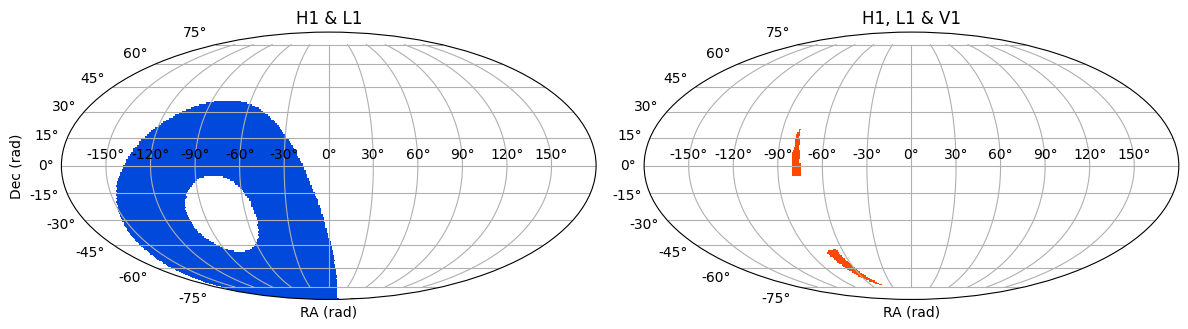

Sky area covered by H1 & L1: 10377.54 square degrees
Sky area covered by H1, L1 & V1: 192.90 square degrees
Improvement in sky area with V1: 53.80 times smaller area
Sky area reduction: 98.14%


<Figure size 640x480 with 0 Axes>

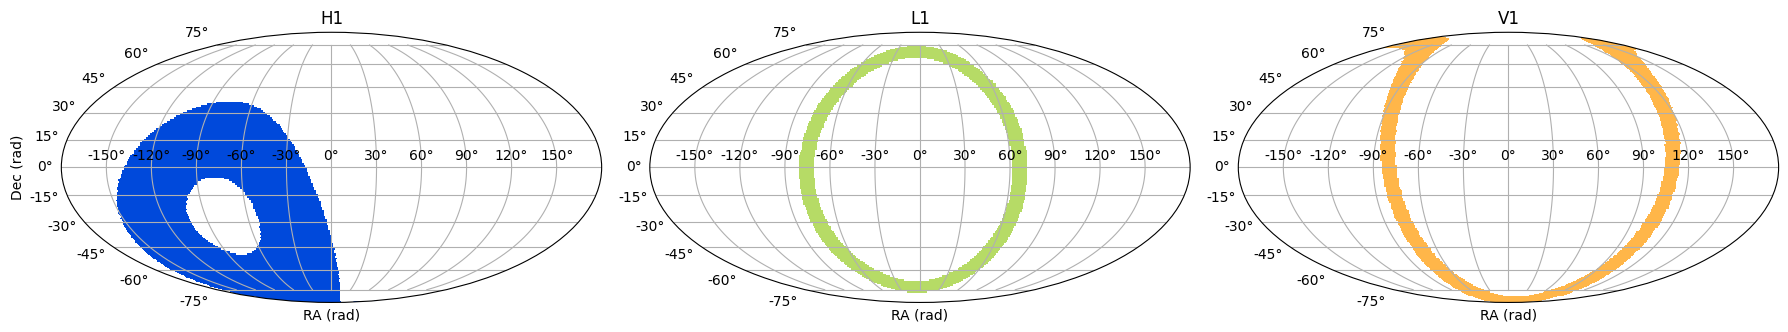

<Figure size 640x480 with 0 Axes>

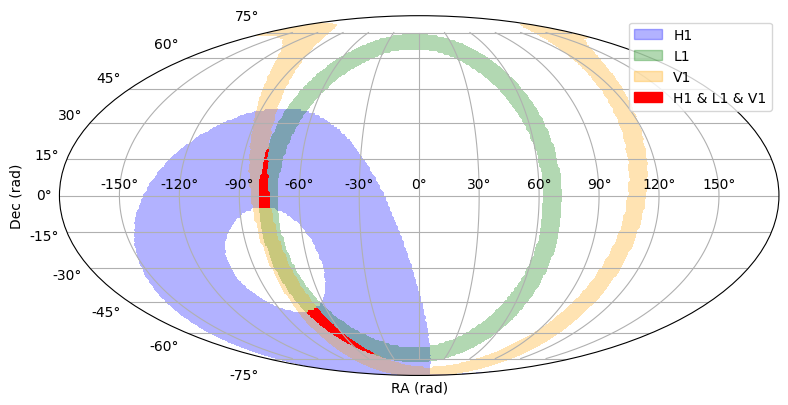

<Figure size 640x480 with 0 Axes>

In [11]:
dts = [tc_H1-tc_L1, tc_H1-tc_V1, tc_L1-tc_V1]
sigmas = [(fwhm_H1 + fwhm_L1)/2, (fwhm_H1 + fwhm_V1)/2, (fwhm_L1 + fwhm_V1)/2]
masks = detector_skymap(time_delays_HLV, dts, sigmas)
plot_detector_skymap(RA, DEC, masks)